In [1]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
from google.colab import files
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#Вычисляем количество комнат
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0]
  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) 
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount
  except: 
    if (roomsCountStr == roomsCountStr): 
      if ("Ст" in roomsCountStr):
        roomsCount = maxRoomCount + 1
  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount)
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2)
  return roomsCount

#Получаем индекс станции метро
def getMetro(d, allMetroNames):
  metroStr = d[1]
  metro = 0
  if (metroStr in allMetroNames):
    metro = allMetroNames.index(metroStr) + 1
  return metro
  
#Получаем тип метро
def getMetroType(d):
  metroTypeStr = d[1] 
  metroTypeClasses = 5
  metroType = metroTypeClasses - 1
  
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота",
                            "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", 
                            "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", 
                            "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", 
                            "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", 
                            "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", 
                      "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]

  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", 
                            "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", 
                            "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", 
                            "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", 
                            "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", 
                            "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", 
                            "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", 
                            "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", 
                            "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская",
                            "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]

  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", 
                            "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", 
                            "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", 
                            "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", 
                            "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", 
                            "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", 
                            "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", 
                            "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", 
                            "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", 
                            "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", 
                            "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", 
                            "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", 
                            "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]

  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3

  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType

#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2]
  metroDistance = 0
  metroDistanceType = 0
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except:
        metroDistance = 0
  metroDistanceClasses = 7
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем данные
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ""
  houseType = 0 
  floor = 0
  floors = 0
  isLastFloor = 0
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
      try:
        slashIndex = houseStr.index("/")
      except:
        print(houseStr)
      try:
        spaceIndex = houseStr.index(" ")
      except:
        print(houseStr)

      floorStr = houseStr[:slashIndex]
      floorsStr = houseStr[slashIndex+1:spaceIndex]
      houseTypeStr = houseStr[spaceIndex+1:]

      try:
        floor = int(floorStr)
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1):
          floor = 1 
        if (floor == floors):
          isLastFloor = 1 
      except:
        floor = 0
      try:
        floors = int(floorsStr)
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
  return floor, floors, isLastFloor, houseType

def getBalcony(d):
  balconyStr = d[4]
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1
  else:
    balcony = 0
  balcony = utils.to_categorical(balcony, 16)
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5]
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1
  else:
    wc = 0
  wc = utils.to_categorical(wc, 14)
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6]
  if ("/" in areaStr):
    slashIndex = areaStr.index("/")
    try:
      area = float(areaStr[:slashIndex])
    except:
      area = 0
  else:
    area = 0
  return area

#Полуаем цену
def getCost(d):
  costStr = d[7]
  try:
    cost = float(costStr)
  except:
    cost = 0
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1]
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  return xTrain

def getYTrain(data):
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  return yTrain

In [12]:
# Очистка текста и превращение в набор слов

def text2Words(text):
  #Удаляем лишние символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

In [13]:
df = pd.read_csv('/content/drive/My Drive/datasets/date_csv/moscow.csv', sep=";") #Загружаем данные в data frame
df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [14]:
print(df.iloc[:,:6].head(20)) #Показываем пример данных (первые 6 колонок)

   Комнат        Метро / ЖД станции От станции        Дом Балкон Санузел
0       1               Шелепиха м.        12п    35/37 М    NaN       2
2       1        Пятницкое шоссе м.        30т    11/14 П      Л       Р
4       1              Планерная м.         5т    11/22 П      Б       С
6       1            Шаболовская м.        12п     8/12 ?      Б       Р
8       1           Бабушкинская м.        15п     4/14 П    NaN       С
10      1               Шелепиха м.        15п     9/36 К    NaN     NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л       Р
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б       С
16      1           Марьина Роща м.        10п     7/14 П     2Б     NaN
18      1                Марьино м.        20п  10/24 М-К    NaN       -
20      1                Марьино м.         5т      5/5 П      Б       С
22      1              Печатники м.         5т     2/12 П      -       С
24      1      Красногвардейская м.         3п    2

In [15]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)

(62504, 109)


In [8]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большо текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [9]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]


In [10]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [17]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [18]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха 0 модуль ошибки 1.767
Эпоха 1 модуль ошибки 1.979
Эпоха 2 модуль ошибки 1.597
Эпоха 3 модуль ошибки 1.37
Эпоха 4 модуль ошибки 1.143
Эпоха 5 модуль ошибки 1.613
Эпоха 6 модуль ошибки 1.113
Эпоха 7 модуль ошибки 1.125
Эпоха 8 модуль ошибки 1.373
Эпоха 9 модуль ошибки 1.364
Эпоха 10 модуль ошибки 1.228
Эпоха 11 модуль ошибки 1.141
Эпоха 12 модуль ошибки 1.406
Эпоха 13 модуль ошибки 1.922
Эпоха 14 модуль ошибки 1.377
Эпоха 15 модуль ошибки 1.164
Эпоха 16 модуль ошибки 1.349
Эпоха 17 модуль ошибки 1.063
Эпоха 18 модуль ошибки 1.053
Эпоха 19 модуль ошибки 1.229
Эпоха 20 модуль ошибки 1.103
Эпоха 21 модуль ошибки 1.008
Эпоха 22 модуль ошибки 1.001
Эпоха 23 модуль ошибки 1.057
Эпоха 24 модуль ошибки 1.133
Эпоха 25 модуль ошибки 1.15
Эпоха 26 модуль ошибки 1.229
Эпоха 27 модуль ошибки 0.995
Эпоха 28 модуль ошибки 1.014
Эпоха 29 модуль ошибки 1.058
Эпоха 30 модуль ошибки 0.991
Эпоха 31 модуль ошибки 1.032
Эпоха 32 модуль ошибки 1.231
Эпоха 33 модуль ошибки 1.096
Эпоха 34 модуль ошибки 1.4

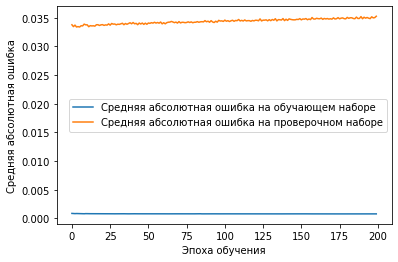

In [19]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) #Выводим усреднённую ошибку в миллионах рублей

#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [21]:
xTrainComments = [] #Тут будет обучающся выборка
allTextComments = "" #Тут будуте все тексты вместе для словаря

#Идём по всем строкам квартир в базе
for d in data1:
    currText = d[-1] #Вытаскиваем примечание к квартире
    try: 
        if (currText == currText): #Проверяем на nan
            allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
        currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку

xTrainComments = np.array(xTrainComments)


In [22]:
max_word_count = 7000
tokenizer = Tokenizer(max_word_count, filters='!"#$%&()*+ஜђ,-.ˇ/²:;<½=>?...\¬xadˇ', split= ' ', oov_token='unk')

In [23]:
%%timeit -n 1 -r 1
tokenizer.fit_on_texts([allTextComments])

1 loop, best of 1: 8.3 s per loop


In [24]:
x_train_token = tokenizer.texts_to_sequences(xTrainComments)

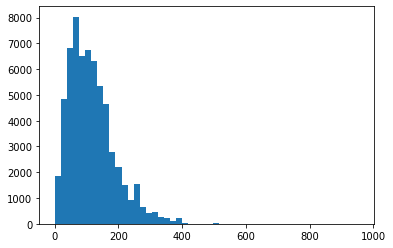

In [25]:
cc= []
for i in x_train_token:
    cc.append(len(i))
plt.hist(cc,bins = 50)
plt.show()

In [26]:
len(x_train_token), len(xTrain)

(62504, 62504)

In [27]:
ind = [len(i) < 300 for i in x_train_token] # Отсекаем все примеры где, длина больше 300
sum(ind)

61036

In [28]:
x_Train = xTrain[ind]
x_train_text = np.array(x_train_token)[ind]

In [29]:
xTrainC01 = tokenizer.sequences_to_matrix(x_train_text, mode ="count")

In [30]:
xTrainC01.shape

(61036, 7000)

In [31]:
y_Train = yTrain[ind]
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(x_Train.shape)
print(xTrainC01.shape)
print(y_Train.shape)

(61036, 109)
(61036, 7000)
(61036,)


In [32]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(x_Train[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = x_Train.copy()
xTrainScaled[:,-1] = xScaler.transform(x_Train[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(x_Train[0])
print(xTrainScaled[0])

(61036, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [33]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(y_Train.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(y_Train.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(y_Train[0])
print(yTrainScaled[0])

(61036, 1)
19500000.0
[0.53415258]


In [34]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [35]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
#Простая Dense сеть    Conv1D, GlobalMaxPool1D
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) #Выводим усреднённую ошибку в миллионах рублей

#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Эпоха 0 модуль ошибки 1.7
Эпоха 1 модуль ошибки 1.547
Эпоха 2 модуль ошибки 1.261
Эпоха 3 модуль ошибки 1.494
Эпоха 4 модуль ошибки 1.666
Эпоха 5 модуль ошибки 1.053
Эпоха 6 модуль ошибки 1.163
Эпоха 7 модуль ошибки 1.172
Эпоха 8 модуль ошибки 1.319
Эпоха 9 модуль ошибки 1.333
Эпоха 10 модуль ошибки 1.131
Эпоха 11 модуль ошибки 0.967
Эпоха 12 модуль ошибки 1.075
Эпоха 13 модуль ошибки 0.995
Эпоха 14 модуль ошибки 0.978
Эпоха 15 модуль ошибки 0.989
Эпоха 16 модуль ошибки 1.031
Эпоха 17 модуль ошибки 0.96
Эпоха 18 модуль ошибки 0.933
Эпоха 19 модуль ошибки 0.97
Эпоха 20 модуль ошибки 0.921
Эпоха 21 модуль ошибки 0.999
Эпоха 22 модуль ошибки 0.946
Эпоха 23 модуль ошибки 0.917
Эпоха 24 модуль ошибки 0.902
Эпоха 25 модуль ошибки 0.896
Эпоха 26 модуль ошибки 0.897
Эпоха 27 модуль ошибки 0.95
Эпоха 28 модуль ошибки 0.885
Эпоха 29 модуль ошибки 0.932
Эпоха 30 модуль ошибки 1.342
Эпоха 31 модуль ошибки 0.865
Эпоха 32 модуль ошибки 0.887
Эпоха 33 модуль ошибки 0.859
Эпоха 34 модуль ошибки 0.979
